# Chroma Keying
1. Full green source image
1. Captured image with green background
    1. create mask by detecting green bg pixels using statistics of the green values. The area must be specified manually.
    1. create mask by background subtraction
1. video processing

* Project: take a vide and apply chroma keying

In [27]:
import os 
from pathlib import Path
import imageio 

import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

In [4]:
def imshow(imlist): # image show for cv2 BGR images
    import numpy 
    if type(imlist) == numpy.ndarray or len(imlist) == 1:
        if type(imlist) == numpy.ndarray:
            plt.imshow(imlist[:,:,::-1]); 
        else:
            plt.imshow(imlist[0][:,:,::-1]); 
        plt.axis(False);
    else:
        fig, axes = plt.subplots(1, len(imlist), figsize=(12,3))
        for ax, im in zip(axes, imlist):
            ax.imshow(im[:,:,::-1])
            ax.set_axis_off()
    #

## Load green screen image
- this image is already processed to remove the background.

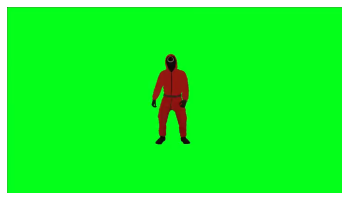

In [5]:
src_img = cv2.imread('pixels/squid_720x480_frame_0.png')
imshow(src_img)

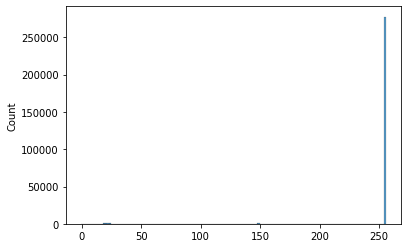

In [6]:
green_channel = src_img[:,:,1]
sns.histplot(green_channel.reshape(-1), discrete=True);

The most common green value is 255.


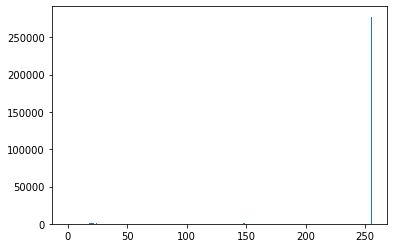

In [7]:
unique_values, counts = np.unique(green_channel.reshape(-1), return_counts=True)
plt.bar(unique_values, counts);
green_key = unique_values[np.argmax(counts)]
print(f"The most common green value is {green_key}.")

(400, 720, 3)


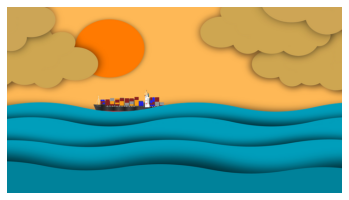

In [8]:
bg_img = cv2.imread('pixels/image-15.png')
bg_img = cv2.resize(bg_img, (src_img.shape[1], src_img.shape[0]))
print(bg_img.shape)
imshow(bg_img);

# Direct Overlay
- python was not born for the for-loops.

In [9]:
def chromaKeyGreen(in_array, keyvalue, bg=None):
    array = in_array.copy()
    if bg is None:
        print('bg zero alloc.')
        bg = np.zeros_like(array, dtype="uint8")
    for r in range(array.shape[0]):
        for c in range(array.shape[1]):
            if array[r,c,1] == keyvalue:
                array[r,c] = bg[r,c]
    return array
#

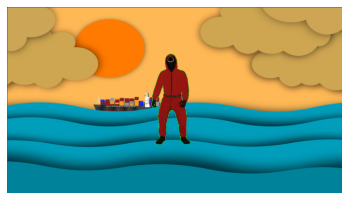

In [10]:
keyed = chromaKeyGreen(src_img, green_key, bg_img)
imshow(keyed)

bg zero alloc.


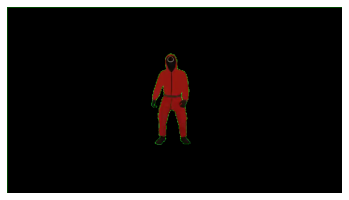

In [11]:
keyed_0 = chromaKeyGreen(src_img, green_key)
imshow(keyed_0)

# Hue analysis

- HSV in OpenCV: [Color Conversion](https://docs.opencv.org/3.4.15/de/d25/imgproc_color_conversions.html)

In [12]:
# hue in [0, 180]
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)  
hsv.dtype

dtype('uint8')

[(0.0, 10000.0)]

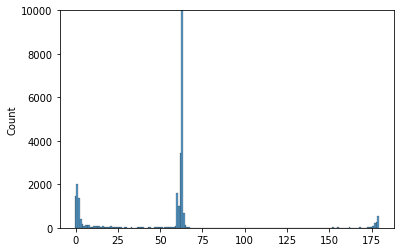

In [13]:
ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True);
ax.set(ylim=[0,10000])

[(0.0, 10000.0), (50.0, 75.0)]

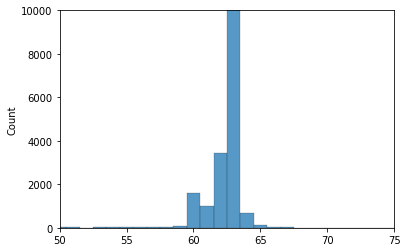

In [14]:
ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True);
ax.set(ylim=[0,10000], xlim=[50, 75])

In [15]:
def chromaKeyGreenRange(in_array, keyrange, bg=None):
    hsv = cv2.cvtColor(in_array, cv2.COLOR_BGR2HSV) 
    hue = hsv[:,:,0]
    array = in_array.copy()
    if bg is None:
        print('bg zero alloc.')
        bg = np.zeros_like(array, dtype="uint8")
    for r in range(array.shape[0]):
        for c in range(array.shape[1]):
            if keyrange[0] <= hue[r,c] < keyrange[1]:
                array[r,c] = bg[r,c]
    return array
#

bg zero alloc.


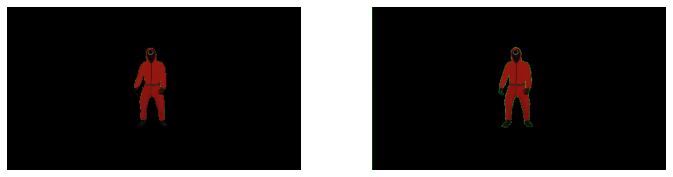

In [16]:
keyRange = [50, 70]
ii = chromaKeyGreenRange(src_img, keyRange)
imshow([ii, keyed_0])

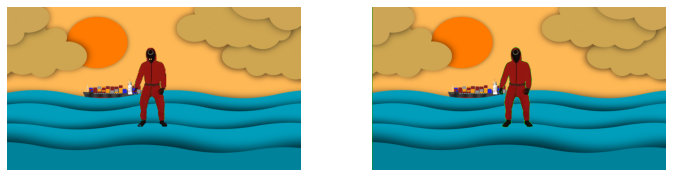

In [17]:
ii2 = chromaKeyGreenRange(src_img, keyRange, bg_img)
imshow([ii2, keyed])

Keeping the object well from killing the green zone has a trade-off.
- occlusion boundary pixels always contain some green component.

# Mask generation

(400, 720)


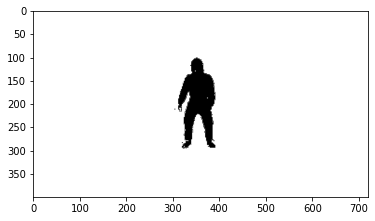

In [18]:
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)  

mask = cv2.inRange(hsv[:,:,0], lowerb=60, upperb=70)
print(mask.shape)
plt.imshow(mask, cmap="gray");

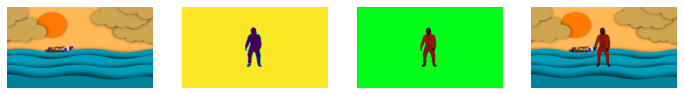

In [19]:
dest = bg_img.copy()
src  = src_img.copy()
composite = cv2.copyTo(dest, mask, src)
imshow([dest, np.expand_dims(mask, -1), src_img, composite])

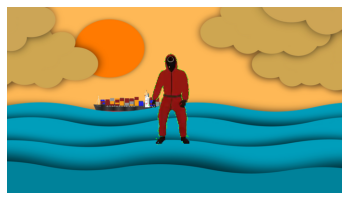

In [20]:
# numerical expression for the composit operation
mask3 = np.expand_dims(mask > 0, -1)
comp = bg_img * mask3 + src_img * (1 - mask3)
imshow(comp)

## A Real Photo taken in a chroma key studio

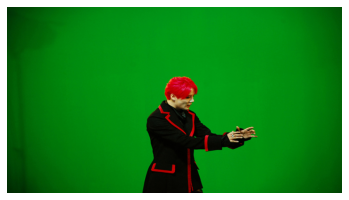

In [21]:
src_img = cv2.imread("pixels/140806_sayastudio2.png")
src_img = cv2.resize(src_img, (bg_img.shape[1], bg_img.shape[0]))
imshow(src_img)

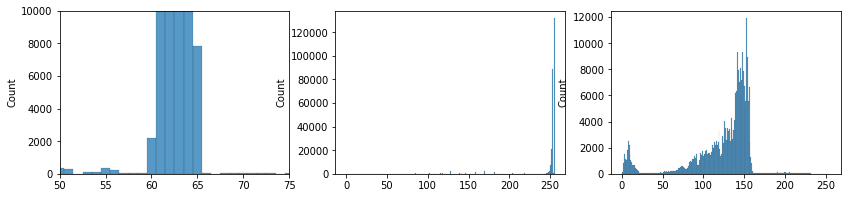

In [22]:
hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)
fig, axes = plt.subplots(1, 3, figsize=(14,3))
ax = sns.histplot(hsv[:,:,0].ravel(), discrete=True, ax=axes[0])
ax.set(xlim=[50, 75], ylim=[0, 10000]);
ax = sns.histplot(hsv[:,:,1].ravel(), discrete=True, ax=axes[1])
ax = sns.histplot(hsv[:,:,2].ravel(), discrete=True, ax=axes[2])

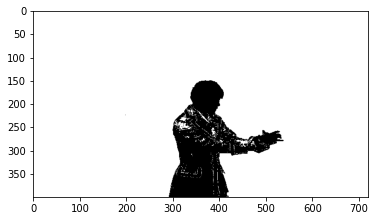

In [23]:
lowerb, upperb = 50, 70  # adjust the two values
mask1 = (lowerb < hsv[:,:,0]) & (hsv[:,:,0] < upperb) # hue only
plt.imshow(mask1, cmap='gray');

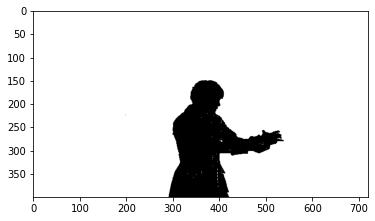

In [24]:
# saturation threshold
mask2 = mask1 & ( 230 < hsv[:,:,1])
plt.imshow(mask2, cmap='gray');

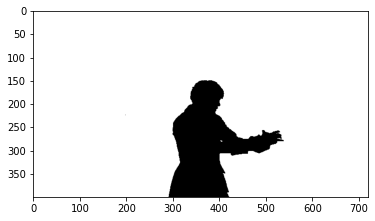

In [25]:
maskfinal = mask2 & ( 30 < hsv[:,:,2])
plt.imshow(maskfinal, cmap='gray');

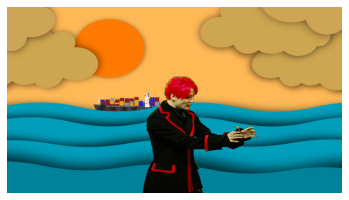

In [26]:
# numerical expression for the composit operation
maskfinal = maskfinal[:,:,np.newaxis]
comp = bg_img * maskfinal + src_img * (1 - maskfinal)
imshow(comp)

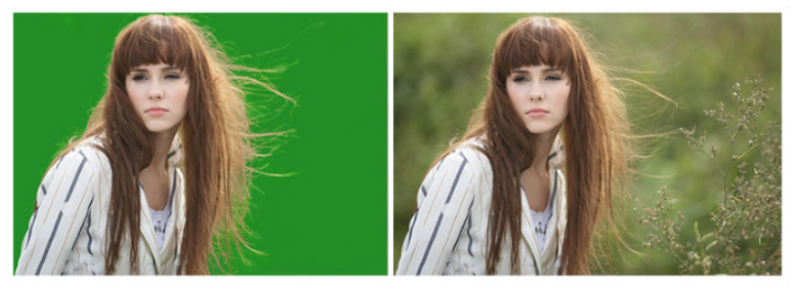

In [32]:
# https://deep-learning-study.tistory.com/134
example = imageio.imread("pixels/chromakey_example.png")

plt.figure(figsize=(14,7))
plt.imshow(example)
plt.axis(False);